#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [ ]:

class NaiveBayes:
    def __init__(self, num_of_bins: int):
        self.priors = {}
        self.likelihoods = {}
        self.num_of_bins = num_of_bins

    def build_classifier(self, train_features: np.ndarray, train_classes: np.ndarray) -> None:
        self._set_priors(train_classes)
        discrete_features = self.data_discretization(train_features, self.num_of_bins)
        self._set_likelihoods(discrete_features, train_classes)

    def _set_priors(self, train_classes: np.ndarray) -> None:
        for single_class in np.unique(train_classes):
            class_prob = np.sum(train_classes == single_class) / len(train_classes)
            self.priors[single_class] = class_prob

    def _set_likelihoods(self, discrete_train_features: np.ndarray, train_classes: np.ndarray) -> None:
        alpha = 0.5

        for single_class in np.unique(train_classes):
            self.likelihoods[single_class] = {}
            features = discrete_train_features[train_classes == single_class]

            num_of_features = discrete_train_features.shape[1]
            for feature_index in range(num_of_features):
                self.likelihoods[single_class][feature_index] = {}
                feature = features[:, feature_index]

                for bin_num in range(1, self.num_of_bins + 1):
                    feature_for_single_bin = feature[feature == bin_num]
                    feature_prob = (len(feature_for_single_bin) + alpha
                                    ) / (len(feature) + alpha)

                    self.likelihoods[single_class][feature_index][bin_num] = feature_prob

    @staticmethod
    def data_discretization(data: np.ndarray, num_of_bins: int = 4) -> np.ndarray:
        copied_data = data.copy()
        num_of_features = data.shape[1]
        for feature_index in range(num_of_features):
            feature_values = data[:, feature_index]
            bins_ranges = np.linspace(np.min(feature_values), np.max(feature_values) + 1e-10, num_of_bins + 1)
            feature_discrete = np.digitize(feature_values, bins_ranges)
            copied_data[:, feature_index] = feature_discrete
        return copied_data

    def predict(self, samples: np.ndarray) -> np.ndarray:
        discrete_samples = self.data_discretization(samples, self.num_of_bins)

        predictions = []
        for sample in discrete_samples:
            posterior_probabilities = {}
            for single_class in self.priors:
                posterior_probability = self.priors[single_class]

                for feature_index, bin_num in enumerate(sample):
                    posterior_probability *= self.likelihoods[single_class][feature_index][bin_num]

                posterior_probabilities[single_class] = posterior_probability
            predicted_class = max(posterior_probabilities, key=lambda k: posterior_probabilities[k])
            predictions.append(predicted_class)

        return np.array(predictions)


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features: np.ndarray, train_classes: np.ndarray) -> None:
        self._set_priors(train_classes)
        self._set_likelihoods(train_features, train_classes)

    def _set_priors(self, train_classes: np.ndarray) -> None:
        for single_class in np.unique(train_classes):
            class_prob = np.sum(train_classes == single_class) / len(train_classes)
            self.priors[single_class] = class_prob

    def _set_likelihoods(self, train_features: np.ndarray, train_classes: np.ndarray) -> None:
        for single_class in np.unique(train_classes):
            self.likelihoods[single_class] = {}
            features = train_features[train_classes == single_class]

            num_of_features = train_features.shape[1]
            for feature_index in range(num_of_features):
                self.likelihoods[single_class][feature_index] = {}
                feature = features[:, feature_index]

                mean = feature.mean()
                std = feature.std()

                if std == 0:
                    std += 1e-10

                self.likelihoods[single_class][feature_index] = {'mean': mean, 'std': std}

    @staticmethod
    def normal_dist_density(x, mean: float, std: float) -> float:
        exp = np.exp(-((x - mean)**2 / (2 * std**2)))
        return (1 / std * (np.sqrt(2 * np.pi))) * exp

    def predict(self, samples: np.ndarray) -> np.ndarray:
        predictions = []
        for sample in samples:
            posterior_likelihoods = {}
            for single_class in self.priors:
                posterior_likelihood = np.log(self.priors[single_class])

                for feature_index, feature_value in enumerate(sample):
                    mean = self.likelihoods[single_class][feature_index]['mean']
                    std = self.likelihoods[single_class][feature_index]['std']
                    normal_dist_dens = self.normal_dist_density(feature_value, mean, std)
                    posterior_likelihood += np.log(normal_dist_dens)

                posterior_likelihoods[single_class] = posterior_likelihood
            predicted_class = max(posterior_likelihoods, key=lambda k: posterior_likelihoods[k])
            predictions.append(predicted_class)

        return np.array(predictions)


## Testy dla podanego zbioru testowego i trenującego

In [ ]:
bayes_classifier = NaiveBayes(num_of_bins=4)
bayes_classifier.build_classifier(x_train, y_train)
print("Naive Bayes Classifier")
print("Predicted classes:\t", end="")
print(bayes_classifier.predict(x_test))
print("Aktual classes:   \t", end="")
print(y_test)

gausian_bayer_classifer = GaussianNaiveBayes()
gausian_bayer_classifer.build_classifier(x_train, y_train)
print("\nGaussian Naive Bayes Classifier")
print("Predicted classes:\t", end="")
print(gausian_bayer_classifer.predict(x_test))
print("Aktual classes:   \t", end="")
print(y_test)

Naive Bayes Classifier
Predicted classes:	[1 2 2 1 0 2 1 0 0 1 2 0 1 2 2]
Aktual classes:   	[1 2 2 1 0 2 1 0 0 1 2 0 1 2 2]

Gaussian Naive Bayes Classifier
Predicted classes:	[1 2 2 1 0 2 1 0 0 1 2 0 1 2 2]
Aktual classes:   	[1 2 2 1 0 2 1 0 0 1 2 0 1 2 2]


## Kod do przeprowadzania testów

In [ ]:

def calc_bayes_accuracy(x_train, x_test, y_train, y_test, num_of_bins: int) -> float:
    bayes_classifier = NaiveBayes(num_of_bins)
    bayes_classifier.build_classifier(x_train, y_train)
    return sum(y_test == bayes_classifier.predict(x_test)) / len(y_test)


def calc_gaussian_accuracy(x_train, x_test, y_train, y_test) -> float:
    gaussian_classifier = GaussianNaiveBayes()
    gaussian_classifier.build_classifier(x_train, y_train)
    return sum(y_test == gaussian_classifier.predict(x_test)) / len(y_test)


## Porównanie prezycji dwóch klasyfikatorów

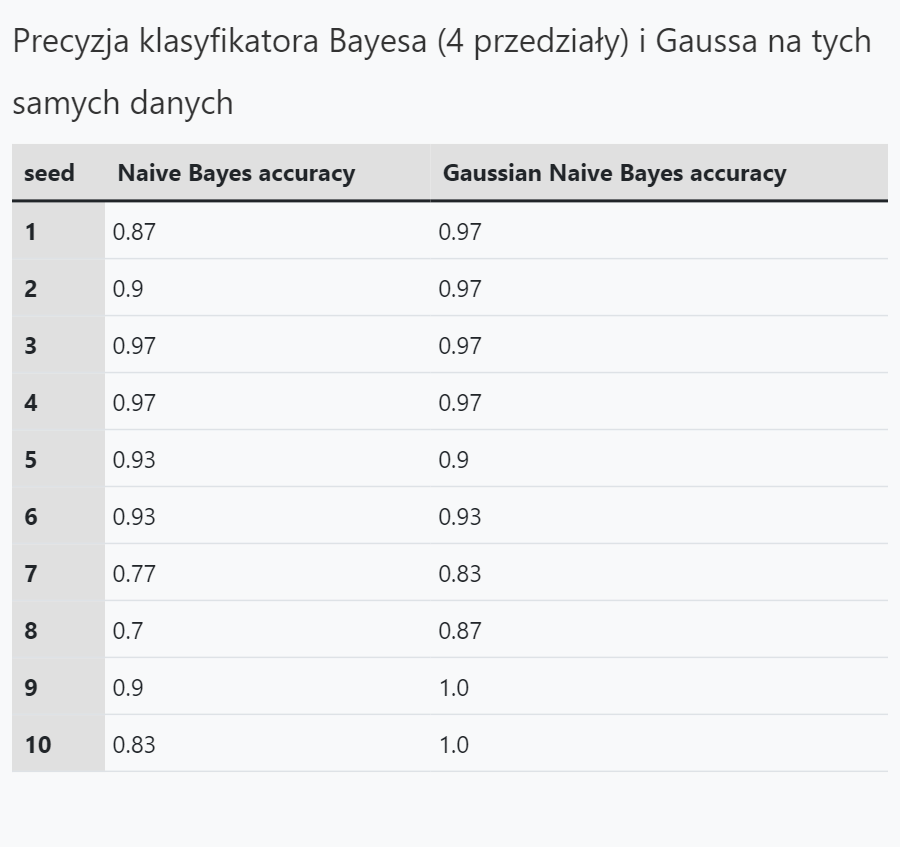

### Obserwacja
- Klasyfikator Bayesa dla danych ciągłych zazwyczaj osiągał wyższą dokładność niż klasyfikator Bayesa dla danych dyskretnych

### Wniosek
- Dyskretyzacja danych może prowadzić do utraty informacji, co może wpłynąć na wydajność klasyfikatora Bayesa dla danych dyskretnych

## Porównanie prezycji dyskretnego klasyfikatora Bayesa ze względu na liczbę przedziałów przy dyskretyzacji


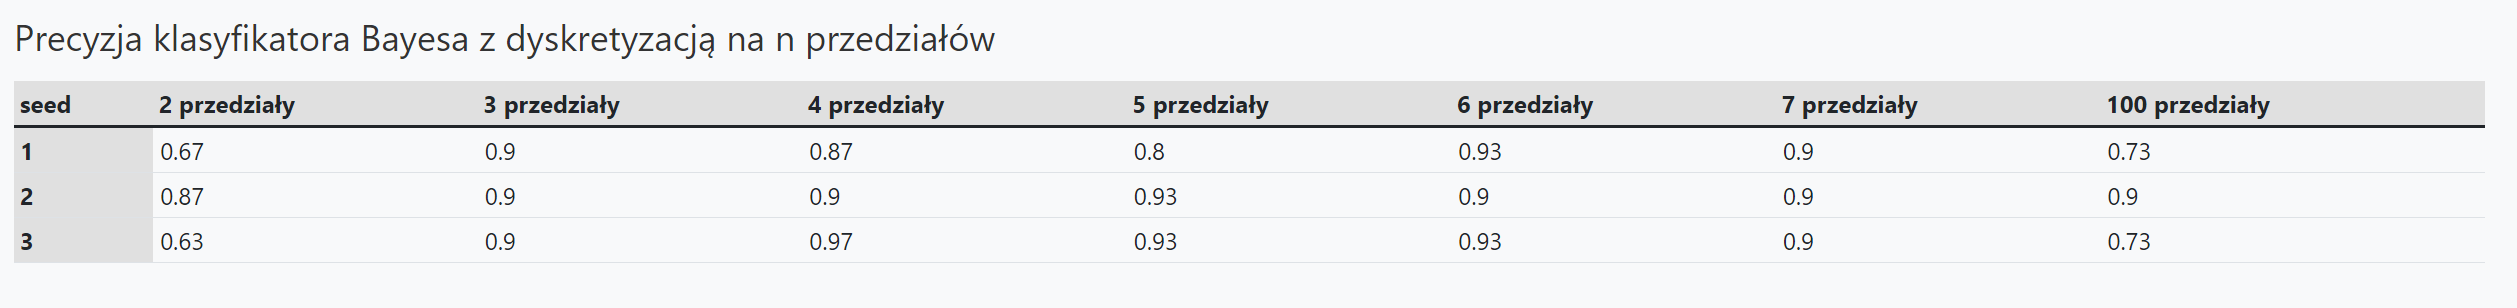


### Wnioski
- zbyt mała liczba przedziałów nie jest wystarczająca do efektywnej dyskretyzacji i klasyfikacji danych (underfitting)
- zbyt wiele przedziałów może prowadzić do nadmiernego dopasowania się do danych treningowych (overfitting)
- odpowiednia liczba przedziałów zależy od konkretnego problemu (w naszym przypadku zbiór Iris nie ma bardzo dużych przedziałów wartości w przyjmowanych cechach więc mała ilość przedziałów wystarcza)

## Porównanie prezycji dyskretnego klasyfikatora Bayesa w zależności od współcznnika Laplace'a (alpha)

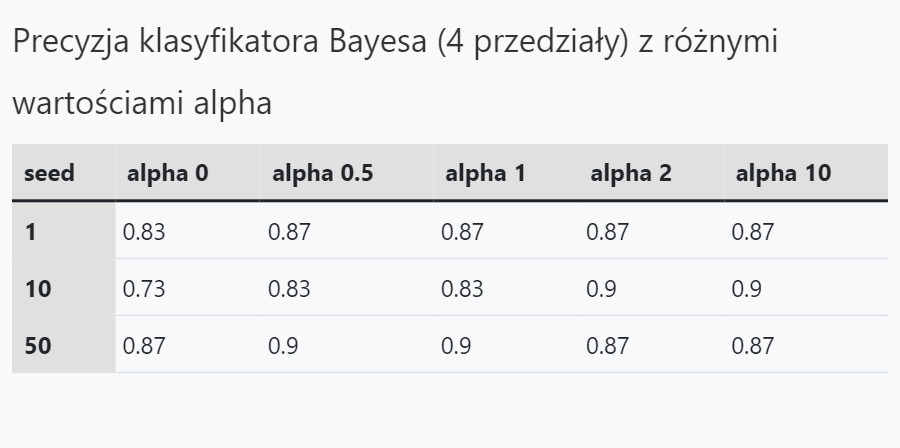

### Wnioski
- trudno jest znaleźć optymalną wartość alpha, ale jest ona bardzo potrzebna aby zapobiegać problemowi zerowego prawdopodobieństwa warunkowego (dochodzi do tego kiedy niektóre zdarzenia nie występują w danych trenignowych)